Notebook basado en el artículo:
What is the expectation maximization algorithm?, by Chuong B Do & Serafim Batzoglou
http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf

Problema:
    
    Se tienen dos monedas con sesgos desconocidos.  Es decir, la probabilidad de que salga cara NO es 1/2, y además es diferente para cada una.  Se busca determinar los valores de esas probabilidades. 
    
    Para eso se realiza el siguiente experimento:
    
    1. Elegir una moneda al azar
    2. sortear esa moneda 10 veces
    3. repetir (1.) 5 veces
    
Al final se tienen en total 50 sorteos de las monedas.

In [231]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

Definir una funcion que muestre la distribucion binomial (muchos resultados de simular una moneda)

In [232]:
def plot_binomial(p=0.5, n=10):
    a=range(n+1)
    fig, ax = plt.subplots(figsize=(6,4))
    y = [0]*(n+1)
    for i in a:
        y[i] =  stats.binom.pmf(i, n, p)
    ax.bar(a,y,label="$p = %.1f$" % p)
    ax.set_ylabel('FMP del nro. de caras')
    ax.set_xlabel('$k$')
    ax.set_ylim((0,0.5))
    ax.set_xlim((-1,n+1))
    ax.legend()
    return fig

Mostrar la distribucion Binomial

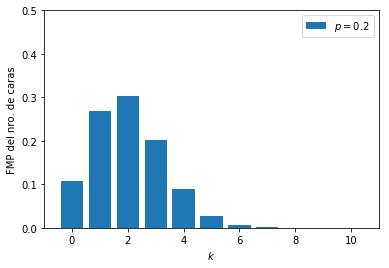

In [233]:
f = plot_binomial(0.2)

## Simular un experimento:

In [300]:
Nexp = 5   # numero de experimentos (monedas)
Nsor = 10  # numero de veces que tiro la moneda en cada experimento
pA = 0.3   # probabilidad de que salga cara en la moneda A
pB = 0.7   # probabilidad de que salga cara en la moneda B
pM = 0.5   # probabiidad de elegir la moneda A
N_itera = 10 # cantidad de iteraciones en el metodo EM
obs = np.empty([Nexp, Nsor], dtype=bool)

In [301]:
def gen_bernoulli(p):
    x = random.random()
    if x<p:
        r = True
    else:
        r = False
    return(r)

In [302]:
def monedas(emA,Nexp):
    As = np.array(["A"]*Nexp)
    Bs = np.array(["B"]*Nexp)
    T = As
    T[emA] = As[emA]
    T[~emA] = Bs[~emA]
    return(T)

In [303]:
def eP(emA, pA, pB, Nexp):
    As = np.array(["A"]*Nexp)
    Bs = np.array(["B"]*Nexp)
    T = As
    T[emA] = As[emA]
    T[~emA] = Bs[~emA]
    return(T)

Elegir monedas:

In [304]:
mA = np.array([gen_bernoulli(pM) for _ in range(Nexp)])
print mA
T = monedas(mA, Nexp)
print(T)

[ True False  True  True  True]
['A' 'B' 'A' 'A' 'A']


Tiradas de las monedas:

In [305]:
for i in range(Nexp):
    
    if(mA[i]):
        p = pA
    else:
        p = pB
        
    obs[i] = [gen_bernoulli(p) for _ in range(Nsor)]

In [306]:
print obs

[[False False  True False  True False False  True  True  True]
 [False  True  True  True False False  True  True  True  True]
 [ True False False False  True  True False  True False  True]
 [False False False False  True False False False False False]
 [False False False  True  True  True False  True False False]]


------------------------------------>> Objetivo: estimar pA y pB <<----------------------------------------

## Estimaciones de la probabilidad: Caso "completo"

![title](EM1.png)

In [307]:
fA = 1.0 * np.sum(obs[mA]) / np.size(obs[mA])
fB = 1.0 * np.sum(obs[~mA]) / np.size(obs[~mA])
print(pA, fA, pB, fB)

(0.3, 0.375, 0.7, 0.7)


/home/marce/TeachJob/Astrometria/pyramid/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


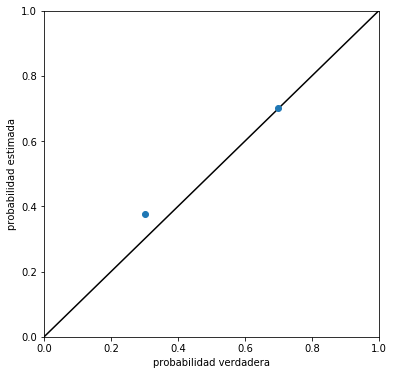

In [308]:
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([0,1],[0,1],"k-")
plt.plot([pA,pB],[fA,fB],"o")
ax.set_xlabel('probabilidad verdadera')
ax.set_ylabel('probabilidad estimada')
ax.set_ylim((0,1))
ax.set_xlim((0,1))
ax.legend()

### Estimaciones de la probabilidad: Caso "incompleto": 
#### Aplicación del algoritmo de expectación-maximización

#### paso 1: asumir valores para los parámetos pA y pB (desconocidos)

In [309]:
epA = 0.6
epB = 0.5

#### paso 2: determinar para cada experimento cual de las monedas es la más probable

In [310]:
# Experimento 1:
print(obs[0])
Ncaras = np.sum(obs[0])
L_A1 = stats.binom.pmf(Ncaras,Nsor,epA)
L_B1 = stats.binom.pmf(Ncaras,Nsor,epB)
print(L_A1, L_B1)

[False False  True False  True False False  True  True  True]
(0.20065812480000034, 0.24609375000000025)


In [311]:
# para los 5 experimentos:
emA = []
for X in obs:
    Ncaras = np.sum(X)
    L_A = stats.binom.pmf(Ncaras,Nsor,epA)
    L_B = stats.binom.pmf(Ncaras,Nsor,epB)
    if(L_A>L_B): 
        S="A"
        emA.append(True)
    else:
        S="B"
        emA.append(False)
    print('La moneda más probable es la {}.  Valores: {} y {}'.format(S, L_A, L_B))
emA = np.array(emA)

La moneda más probable es la B.  Valores: 0.2006581248 y 0.24609375
La moneda más probable es la A.  Valores: 0.214990848 y 0.1171875
La moneda más probable es la B.  Valores: 0.2006581248 y 0.24609375
La moneda más probable es la B.  Valores: 0.001572864 y 0.009765625
La moneda más probable es la B.  Valores: 0.111476736 y 0.205078125


In [312]:
print(emA)
print(monedas(emA, Nexp))

[False  True False False False]
['B' 'A' 'B' 'B' 'B']


#### paso 3: 

#### IDEA: _asumo_ estos valores para las variables latentes y estimo los parámetros usando _maximum likelihood_

In [324]:
# Lo mismo que para el caso completo, pero usando emA en lugar de mA:
fA = 1.0 * np.sum(obs[emA]) / np.size(obs[emA])
fB = 1.0 * np.sum(obs[~emA]) / np.size(obs[~emA])
print(pA, fA, pB, fB)

(0.3, 0.5, 0.7, 0.275)


#### Repito lo mismo hasta convergencia:

In [314]:
# estima inicial
epA = 0.9
epB = 0.1
print(emA, epA, epB)

for _ in range(10):
    emA = []
    for X in obs:
        Ncaras = np.sum(X)
        L_A = stats.binom.pmf(Ncaras,Nsor,epA)
        L_B = stats.binom.pmf(Ncaras,Nsor,epB)
        if(L_A>L_B): 
            emA.append(True)
        else:
            emA.append(False)
    emA = np.array(emA)
    
    epA = 1.0 * np.sum(obs[emA]) / np.size(obs[emA])
    epB = 1.0 * np.sum(obs[~emA]) / np.size(obs[~emA])
    print(emA, epA, epB)

(array([False,  True, False, False, False], dtype=bool), 0.9, 0.1)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)
(array([False,  True, False, False, False], dtype=bool), 0.7, 0.375)


#### EM: en lugar de elegir la moneda "más probable", tomo una probabilidad para cada moneda

En la version anterior, asignamos "probabilidades" 0 y 1 a las monedas según cual era la más probable, es decir, asumimos la variable latente como conocida.   Ahora vamos a asignarle una probabilidad a cada moneda.

Para el experimento 1:

In [323]:
for i in range(Nexp):    
    if(mA[i]):
        p = pA
    else:
        p = pB        
    obs[i] = [gen_bernoulli(p) for _ in range(Nsor)]

In [316]:
Ncaras = np.sum(obs[0])

L_A = stats.binom.pmf(Ncaras,Nsor,epA)
L_B = stats.binom.pmf(Ncaras,Nsor,epB)

# EXPECTACION

mpA = L_A / (L_A + L_B)
mpB = L_B / (L_A + L_B)

print (L_A, L_B, mpA, mpB)

(0.036756909000000039, 0.2475280780345204, 0.12929599056012298, 0.87070400943987702)


El **modelo** ahora es la distribunción Binomial con los parámetros estimados **mpA** y **mpB**

Ahora hacemos el paso de MAXIMIZACION

In [317]:
eCA = Ncaras*mpA
eXA = Ncaras*mpA
eCB = Ncaras*mpB
eXB = Ncaras*mpB

print(eCA, eXA, eCB, eXB)

(0.5171839622404919, 0.5171839622404919, 3.4828160377595081, 3.4828160377595081)


Para los 5 experimentos:

In [322]:
eCAT = []
eXAT = []
eCBT = []
eXBT = []

for X in obs:    
    Ncaras = np.sum(X)
    L_A = stats.binom.pmf(Ncaras,Nsor,epA)
    L_B = stats.binom.pmf(Ncaras,Nsor,epB)
    mpA = L_A / (L_A + L_B)
    mpB = L_B / (L_A + L_B)
    
    eCA = Ncaras*mpA
    eCAT.append(eCA)
    
    eXA = (Nsor-Ncaras)*mpA
    eXAT.append(eXA)    
    
    eCB = Ncaras*mpB
    eCBT.append(eCB)
        
    eXB = (Nsor-Ncaras)*mpB
    eXBT.append(eXB)
        
print(np.sum(eCAT), np.sum(eXAT), np.sum(eCBT), np.sum(eXBT))

(8.9551990099371093, 16.092530458547571, 17.044800990062893, 7.9074695414524268)


![title](EM2.png)

In [319]:
epA = np.sum(eCAT) / (np.sum(eCAT) + np.sum(eXAT))
epB = np.sum(eCBT) / (np.sum(eCBT) + np.sum(eXBT))

print(epA, epB)

(0.69168978615804322, 0.36481599750832866)


## PASO 3: EM

In [320]:
epA = 0.4
epB = 0.6

ipA = []
ipB = []

for itera in range(N_itera):

    eCAT = []
    eXAT = []
    eCBT = []
    eXBT = []

    for X in obs:
               
        Ncaras = np.sum(X)
        L_A = stats.binom.pmf(Ncaras,Nsor,epA)
        L_B = stats.binom.pmf(Ncaras,Nsor,epB)
        mpA = L_A / (L_A + L_B)
        mpB = L_B / (L_A + L_B)
        
        eCA = Ncaras*mpA
        eCAT.append(eCA)
        
        eXA = (Nsor-Ncaras)*mpA
        eXAT.append(eXA)    
        
        eCB = Ncaras*mpB
        eCBT.append(eCB)
            
        eXB = (Nsor-Ncaras)*mpB
        eXBT.append(eXB)
        
    epA = np.sum(eCAT) / (np.sum(eCAT) + np.sum(eXAT))
    epB = np.sum(eCBT) / (np.sum(eCBT) + np.sum(eXBT))
    
    ipA.append(epA)
    ipB.append(epB)
    
    print(itera+1, epA, epB)
    

(1, 0.37790152904355501, 0.64674799847502851)
(2, 0.36290759257724142, 0.66910264539125974)
(3, 0.35812412514287212, 0.67779305348518137)
(4, 0.35721116022906191, 0.68097545248381264)
(5, 0.35721430712781593, 0.68219825813696122)
(6, 0.35733689891401621, 0.68270145854935116)
(7, 0.35742739191107809, 0.68292032662054969)
(8, 0.35747889418372869, 0.68301913103217926)
(9, 0.35750561125199026, 0.68306476345475009)
(10, 0.35751890340054654, 0.68308612078148456)


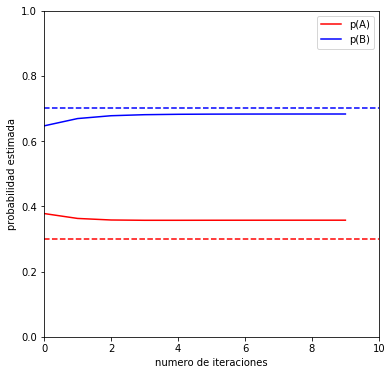

In [321]:
x = range(N_itera)

fig, ax = plt.subplots(figsize=(6,6))
l1 = plt.plot(x, ipA,"r-", label="A")
l2 = plt.plot(x, ipB,"b-", label="B")
ax.axhline(y=pA, color='r', linestyle='--')
ax.set_xlabel('numero de iteraciones')
ax.axhline(y=pB, color='b', linestyle='--')
ax.set_ylabel('probabilidad estimada')
ax.set_ylim((0,1))
ax.set_xlim((0,N_itera))
ax.legend(labels=["p(A)", "p(B)"])